# Tutorial 2

**Alloying elements in recycling**.

A recycling system with two end-of-life (EoL) products, two scrap types, one secondary material, and several types of losses are studied. Three chemical elements are considered: iron, copper, and manganese. A time horizon of 30 years [1980-2010], five processes, and time-dependent parameters are analysed. The processes have element-specific yield factors, meaning that the loss rates depend on the chemical element considered. These values are given below.

The research questions are:
+ "How much copper accumulates in the secondary steel assuming that all available scrap is remelted?"
+ "How much manganese is lost in the remelting process assuming that all available scrap is remelted?
+ "What is more effective in reducing the copper concentraction of secondary steel: A reduction of the shredding yield factor for copper from EoL machines into steel scrap of 25% or an increase in the EoL buildings flow by 25%? (All other variables and parameters remaining equal)"

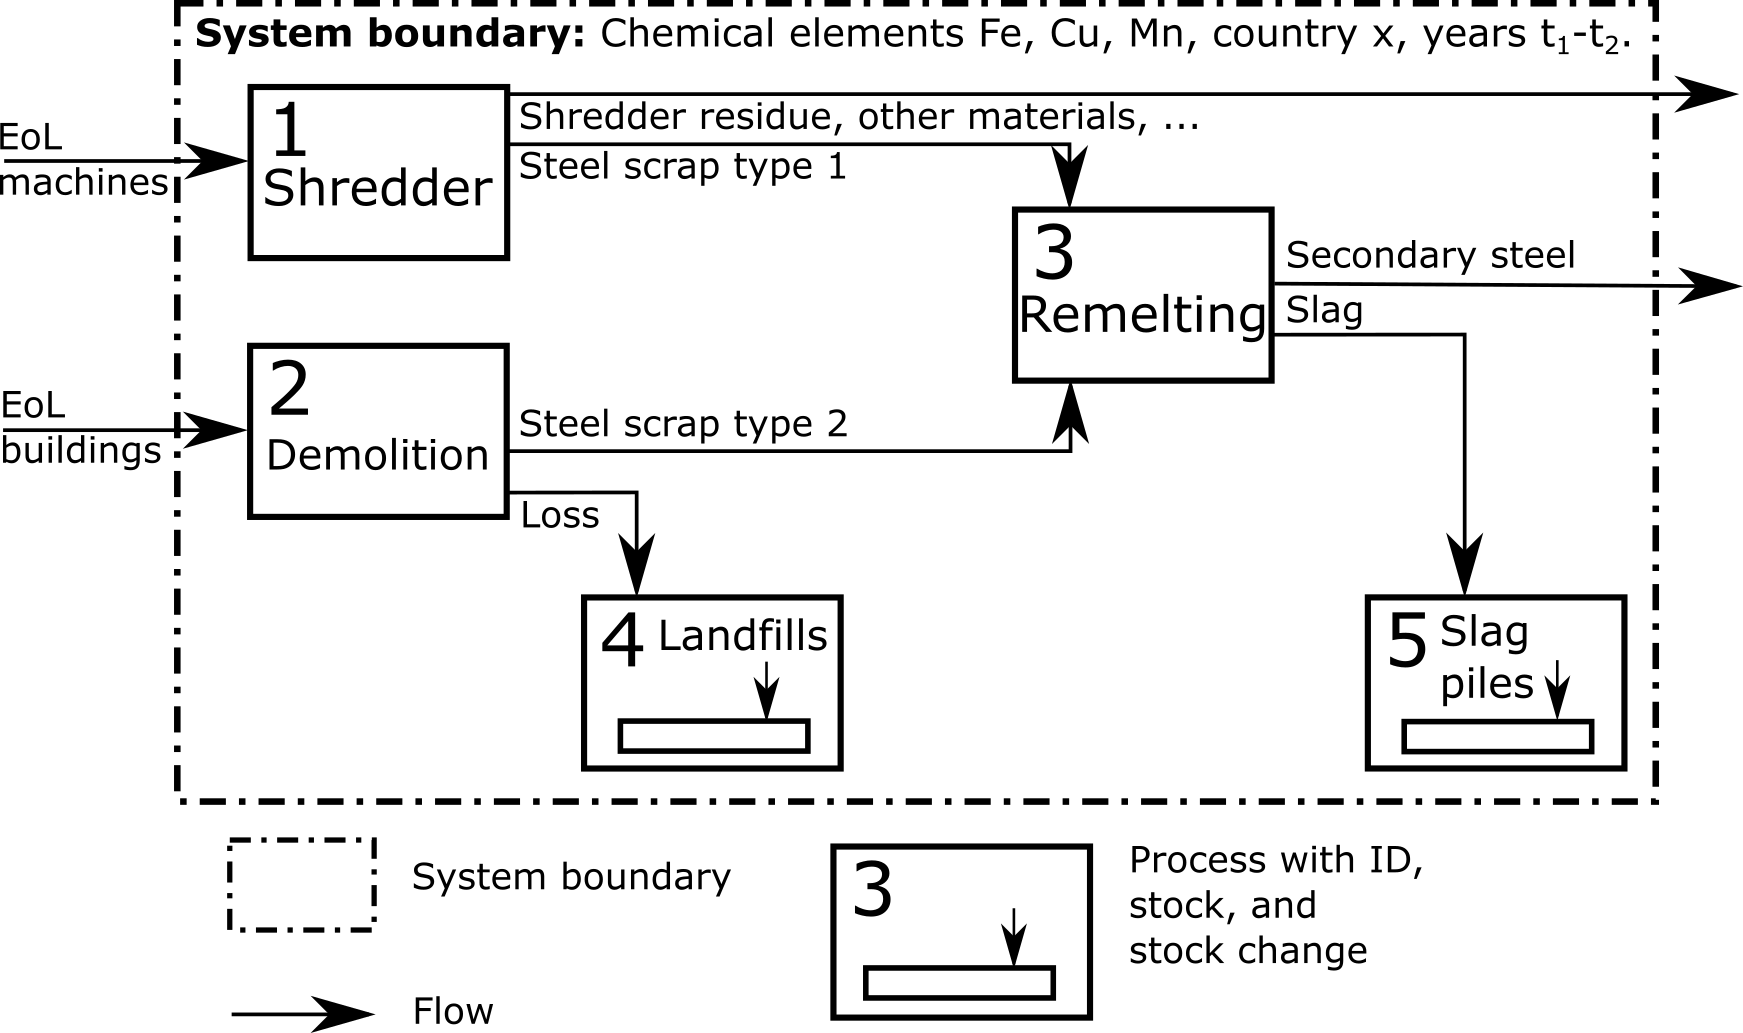

The model equations are as follows:
+ $F_{1\_3}(t,e) = \Gamma_1(e) \cdot F_{0\_1}(t,e) $ (shredder yield factor)
+ $F_{1\_0}(t,e) = (1 - \Gamma_1(e)) \cdot F_{0\_1}(t,e) $ (mass balance)

+ $F_{2\_3}(t,e) = \Gamma_2(e) \cdot F_{0\_2}(t,e) $ (demolition yield factor)
+ $F_{2\_4}(t,e) = (1 - \Gamma_2(e)) \cdot F_{0\_2}(t,e) $ (mass balance)

+ $F_{3\_0}(t,e) = \Gamma_3(e) \cdot (F_{1\_3}(t,e)+F_{2\_3}(t,e)) $ (remelting yield factor)
+ $F_{3\_5}(t,e) = (1 - \Gamma_3(e)) \cdot (F_{1\_3}(t,e)+F_{2\_3}(t,e)) $ (mass balance)

Here the index letters t denote the model time and e the chemical element. 
We will now programm this solution into ODYM. The two inflows $F_{0\_1}(t,e)$ and $F_{0\_2}(t,e)$ as well as the three yield factors are given below.

## Load ODYM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import odym.classes as msc # import the ODYM class file
import odym.functions as msf # import the ODYM function file
import odym.dynamic_stock_model as dsm # import the dynamic stock model library

## Define MFA System 

With the model imported, we can now set up the system definition. The 'classical' elements of the system definition in MFA include: The processes, flows, and stocks, the material, the region, and the time frame studied. Next to these elements, ODYM features/requires the following elements to be specified:
+ The list of chemical elements considered (Fe, Cu, and Mn)
+ The classification(s) of the system variables (stocks and flows): Which materials, products, regions, or waste groups are considered? (This feature is not used here)
+ An index letter to quickly/directly access a model aspect.
+ A dictionary of model parameters

For all these items ODYM has a specific structure, which is used below.

First, we define a classification of all objects flowing and accumulating in stocks:

In [2]:
ModelClassification  = {} # Create dictionary of model classifications

ModelClassification['Time'] = msc.Classification(
    Name='Time',
    Dimension='Time',
    ID=1,
    Items=list(np.arange(1980,2011))
)
# Classification for time labelled 'Time' must always be present, with Items containing a list of odered integers representing years, months, or other discrete time intervals

ModelClassification['Element'] = msc.Classification(
    Name='Elements',
    Dimension='Element',
    ID=2,
    Items=['Fe','Cu','Mn']
)
# Classification for elements labelled 'Element' must always be present, with Items containing a list of the symbols of the elements covered.

# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start

That dictionary of classifications enteres the index table defined for the system. The indext table lists all aspects needed and assigns a classification and index letter to each aspect.

In [3]:
IndexTable = pd.DataFrame({'Aspect'        : ['Time','Element'], # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect "time"', 'Model aspect "Element"'],
                           'Dimension'     : ['Time','Element'], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification[Aspect] for Aspect in ['Time','Element']],
                           'IndexLetter'   : ['t','e']}) # Unique one letter (upper or lower case) indices to be used later for calculations.

IndexTable.set_index('Aspect', inplace = True) # Default indexing of IndexTable, other indices are produced on the fly

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<odym.classes.Classification object at 0x123aa...,t
Element,"Model aspect ""Element""",Element,<odym.classes.Classification object at 0x123a3...,e


We can now define our MFA system: 

In [ ]:
Dyn_MFA_System = msc.MFAsystem(
    Name='RecyclingSystem', 
    Geogr_Scope='TestRegion', 
    Unit='kt', 
    ProcessList=[], 
    FlowDict={}, 
    StockDict={},
    ParameterDict={}, 
    Time_Start=Model_Time_Start, 
    Time_End=Model_Time_End, 
    IndexTable=IndexTable, 
    Elements=IndexTable.loc['Element'].Classification.Items
)

This system has a name, a geographical scope, a system-wide unit, a time frame, an index table with all aspects defined, and a list of chemical elements considered.

## Inserting Data into the MFA System

It is lacking a list of processes, stocks, flows, and parameters, and these are now defined and inserted into the system:

In [5]:
# Start with empty process list, only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList = [] 
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Environment' , ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Shredder'    , ID   = 1))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Demolition'  , ID   = 2))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Remelting'   , ID   = 3))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Landfills'   , ID   = 4))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Slag piles'  , ID   = 5))

# Print list of processes:
Dyn_MFA_System.ProcessList

Now, we define the parameter values for the inflow and yield parameters:

In [6]:
Values_Par_EoL_Machines  = np.arange(15.5,31,0.5) # linear growth of that flow at growth rate of 0.5 kt/yr
Values_Par_EoL_Buildings = np.arange(120,365,8)   # linear growth of that flow at growth rate of 8 kt/yr

Composition_Par_EoL_Machines  = np.array([0.8,0.15,0.05]) # 80% Fe, 15% Cu, 5% Mn in EoL machines
Composition_Par_EoL_Buildings = np.array([0.95,0.045,0.005]) # 95% Fe, 4.5% Cu, 0.5% Mn in EoL buildings

Yield_Par_Shredder   = np.array([0.92,0.1,0.92]) # Yield for EoL Machine into scrap: Fe: 92%, Cu: 10%, Mn: 92%.
Yield_Par_Demolition = np.array([0.95,0.02,0.95]) # Yield for EoL Building into scrap: Fe: 95%, Cu: 2%, Mn: 95%.
Yield_Par_Remelting  = np.array([0.96,1,0.5]) # Yield for EoL Machine into scrap: Fe: 96%, Cu: 100%, Mn: 50%.

ParameterDict = {}

# Define parameters for inflow of EoL machines and buildings with indices 'te' (years x element) and matching time series Values (array with size 31 x 3).
# In a more advanced setup the parameters are defined in a data template and then read into the software.
ParameterDict['F_0_1']  = msc.Parameter(Name = 'Inflow_Eol_Machines', ID = 1, P_Res = 1,
                                        MetaData = None, Indices = 'te',
                                        Values = np.einsum('t,e->te',Values_Par_EoL_Machines,Composition_Par_EoL_Machines),
                                        Unit = 'kt/yr')
ParameterDict['F_0_2']  = msc.Parameter(Name = 'Inflow_Eol_Buildings', ID = 2, P_Res = 2,
                                        MetaData = None, Indices = 'te',
                                        Values = np.einsum('t,e->te',Values_Par_EoL_Buildings,Composition_Par_EoL_Buildings), 
                                        Unit = 'kt/yr')

# Define parameter yield (gamma) with index 'e' (element) and matching time series Values(array with size 3).
# In a more advanced setup the parameters are defined in a data template and then read into the software.
ParameterDict['Gamma_1'] = msc.Parameter(Name = 'Shredding yield',  ID = 3, P_Res = 1,
                                         MetaData = None, Indices = 'e',
                                         Values = Yield_Par_Shredder, Unit = '1')
ParameterDict['Gamma_2'] = msc.Parameter(Name = 'Demolition yield', ID = 4, P_Res = 2,
                                         MetaData = None, Indices = 'e', 
                                         Values = Yield_Par_Demolition, Unit = '1')
ParameterDict['Gamma_3'] = msc.Parameter(Name = 'Remelting yield',  ID = 5, P_Res = 3,
                                         MetaData = None, Indices = 'e', 
                                         Values = Yield_Par_Remelting, Unit = '1')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

The flows, stocks changes, and stocks are as follows:

In [7]:
# Define the flows of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name = 'Input EoL Machines', P_Start = 0, P_End = 1,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_0_2'] = msc.Flow(Name = 'Input EoL Buildings', P_Start = 0, P_End = 2,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_1_3'] = msc.Flow(Name = 'Scrap type 1', P_Start = 1, P_End = 3,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_1_0'] = msc.Flow(Name = 'Shredder residue', P_Start = 1, P_End = 0,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_2_3'] = msc.Flow(Name = 'Scrap type 2', P_Start = 2, P_End = 3,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_2_4'] = msc.Flow(Name = 'Loss', P_Start = 2, P_End = 4,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_0'] = msc.Flow(Name = 'Secondary steel', P_Start = 3, P_End = 0,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_5'] = msc.Flow(Name = 'Slag', P_Start = 3, P_End = 5,
                                            Indices = 't,e', Values=None)

Dyn_MFA_System.StockDict['S_4']   = msc.Stock(Name = 'Landfill stock', P_Res = 4, Type = 0,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['dS_4']  = msc.Stock(Name = 'Landfill stock change', P_Res = 4, Type = 1,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['S_5']   = msc.Stock(Name = 'Slag pile stock', P_Res = 5, Type = 0,
                                              Indices = 't,e', Values=None)
Dyn_MFA_System.StockDict['dS_5']  = msc.Stock(Name = 'Slag pile stock change', P_Res = 5, Type = 1,
                                              Indices = 't,e', Values=None)

# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_FlowValues() 

In [8]:
# Check whether flow value arrays match their indices, etc. See method documentation.
Dyn_MFA_System.Consistency_Check() 

(True, True, True)

## Programming a Solution of the MFA System
Now the system definition is complete, and we can program the model solution, making good use of np's einsum function:

In [9]:
Dyn_MFA_System.FlowDict['F_0_1'].Values = Dyn_MFA_System.ParameterDict['F_0_1'].Values
Dyn_MFA_System.FlowDict['F_0_2'].Values = Dyn_MFA_System.ParameterDict['F_0_2'].Values
Dyn_MFA_System.FlowDict['F_1_3'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_1'].Values,
                                                    Dyn_MFA_System.ParameterDict['Gamma_1'].Values)
Dyn_MFA_System.FlowDict['F_1_0'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_1'].Values,1 - Dyn_MFA_System.ParameterDict['Gamma_1'].Values)
Dyn_MFA_System.FlowDict['F_2_3'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_2'].Values,
                                                    Dyn_MFA_System.ParameterDict['Gamma_2'].Values)
Dyn_MFA_System.FlowDict['F_2_4'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_2'].Values,
                                                    1 - Dyn_MFA_System.ParameterDict['Gamma_2'].Values)
Dyn_MFA_System.FlowDict['F_3_0'].Values = np.einsum('te,e->te',
                                                    (Dyn_MFA_System.FlowDict['F_1_3'].Values + Dyn_MFA_System.FlowDict['F_2_3'].Values),
                                                    Dyn_MFA_System.ParameterDict['Gamma_3'].Values)
Dyn_MFA_System.FlowDict['F_3_5'].Values = np.einsum('te,e->te',
                                                    (Dyn_MFA_System.FlowDict['F_1_3'].Values + Dyn_MFA_System.FlowDict['F_2_3'].Values), 
                                                    1 - Dyn_MFA_System.ParameterDict['Gamma_3'].Values)

Dyn_MFA_System.StockDict['dS_4'].Values = Dyn_MFA_System.FlowDict['F_2_4'].Values
Dyn_MFA_System.StockDict['dS_5'].Values = Dyn_MFA_System.FlowDict['F_3_5'].Values

Dyn_MFA_System.StockDict['S_4'].Values = Dyn_MFA_System.StockDict['dS_4'].Values.cumsum(axis =0)
Dyn_MFA_System.StockDict['S_5'].Values = Dyn_MFA_System.StockDict['dS_5'].Values.cumsum(axis =0)

### 5) Mass-balance-check
One major advantage of the ODYM system structure is that mass balance checks can be performed automatically using unit-tested routines without further programming need:

In [10]:
Bal = Dyn_MFA_System.MassBalance()
# dimensions of balance are: time step x process x chemical element
print(Bal.shape)
# reports the sum of all absolute balancing errors by process.
print(np.abs(Bal).sum(axis = 0).sum(axis = 1)) 

(31, 6, 3)
[6.63247235e-13 3.30430128e-14 3.02889658e-13 2.98427949e-13
 0.00000000e+00 0.00000000e+00]


The ODYM mass balance array reports the balance for each chemical element, each year, and each process, including the system balance (process 0).

It shows that all processes are balanced with high precision. 

The entire system is mass-balanced.

## Research Questions

We now address the research questions. First, we plot the amount of copper in the secondary steel, both in absolute terms and in %:

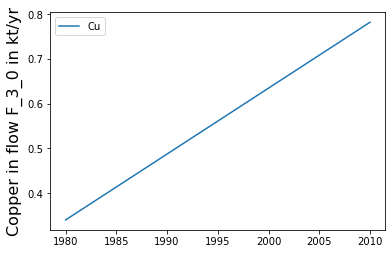

In [11]:
plt.set_loglevel("info") 
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        Dyn_MFA_System.FlowDict['F_3_0'].Values[:,1])
ax.set_ylabel('Copper in flow F_3_0 in kt/yr', fontsize =16)
ax.legend(['Cu'], loc='upper left')

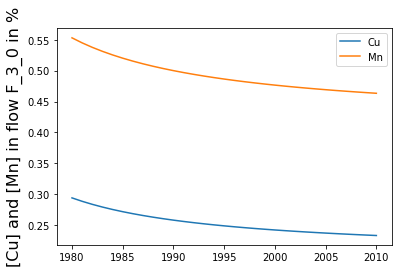

In [12]:
plt.set_loglevel("info") 
Concentration_F_3_0 = np.einsum('te,t->te',
                                Dyn_MFA_System.FlowDict['F_3_0'].Values, 
                                1 / Dyn_MFA_System.FlowDict['F_3_0'].Values.sum(axis=1))
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        100* Concentration_F_3_0[:,1::])
ax.set_ylabel('[Cu] and [Mn] in flow F_3_0 in %', fontsize =16)
ax.legend(['Cu','Mn'])

The answer to the first question is: The copper flow in the secondary steel increases linearly from 0.34 kt/yr in 1980 to 0.78 kt/yr in 2010. The concentration of copper declines in a hyperbolic curve from 0.294% in 1980 to 0.233% in 2010.

That concentration is below 0.4% at all times, the latter being the treshold for construction grade steel, but above 0.04%, which is the threshold for automotive steel.

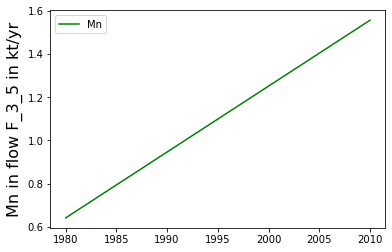

In [13]:
plt.set_loglevel("info") 
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
        Dyn_MFA_System.FlowDict['F_3_5'].Values[:,2], color = 'g')
ax.set_ylabel('Mn in flow F_3_5 in kt/yr', fontsize =16)
ax.legend(['Mn'], loc='upper left')

The answer to the second question is: The manganese flow in the slag from steelmaking increases linearly from 0.64 kt/yr in 1980 to 1.56 kt/yr in 2010. That is about 47% of the total incoming Mn. 

To answer the third question we change the parameter values and recalculate the entire system.

Case a) 

In [14]:
Yield_Par_Shredder_Va = np.array([0.92,0.075,0.92]) # Yield for EoL Machine into scrap: Fe: 92%, Cu: 7.5% (25% reduction from 10%), Mn: 92%.
ParameterDict['Gamma_1'].Values = Yield_Par_Shredder_Va

Dyn_MFA_System.FlowDict['F_0_1'].Values = Dyn_MFA_System.ParameterDict['F_0_1'].Values
Dyn_MFA_System.FlowDict['F_0_2'].Values = Dyn_MFA_System.ParameterDict['F_0_2'].Values
Dyn_MFA_System.FlowDict['F_1_3'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_1'].Values,
                                                    Dyn_MFA_System.ParameterDict['Gamma_1'].Values)
Dyn_MFA_System.FlowDict['F_1_0'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_1'].Values,1 - Dyn_MFA_System.ParameterDict['Gamma_1'].Values)
Dyn_MFA_System.FlowDict['F_2_3'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_2'].Values,
                                                    Dyn_MFA_System.ParameterDict['Gamma_2'].Values)
Dyn_MFA_System.FlowDict['F_2_4'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_2'].Values,1 - Dyn_MFA_System.ParameterDict['Gamma_2'].Values)
Dyn_MFA_System.FlowDict['F_3_0'].Values = np.einsum('te,e->te',
                                                    (Dyn_MFA_System.FlowDict['F_1_3'].Values + Dyn_MFA_System.FlowDict['F_2_3'].Values),
                                                    Dyn_MFA_System.ParameterDict['Gamma_3'].Values)
Dyn_MFA_System.FlowDict['F_3_5'].Values = np.einsum('te,e->te',
                                                    (Dyn_MFA_System.FlowDict['F_1_3'].Values + Dyn_MFA_System.FlowDict['F_2_3'].Values), 
                                                    1 - Dyn_MFA_System.ParameterDict['Gamma_3'].Values)


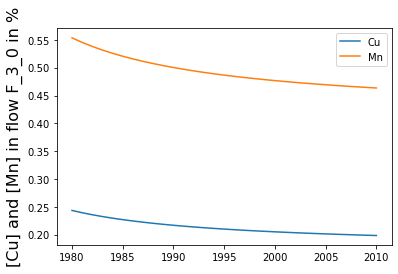

In [15]:
plt.set_loglevel("info") 
Concentration_F_3_0_Va = np.einsum('te,t->te',
                                   Dyn_MFA_System.FlowDict['F_3_0'].Values, 
                                   1 / Dyn_MFA_System.FlowDict['F_3_0'].Values.sum(axis=1))
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        100* Concentration_F_3_0_Va[:,1::])
ax.set_ylabel('[Cu] and [Mn] in flow F_3_0 in %', fontsize =16)
ax.legend(['Cu','Mn'])

Case b)

In [16]:
ParameterDict['F_0_2'].Values = ParameterDict['F_0_2'].Values * 1.25 # Process 25% more EoL buildings
ParameterDict['Gamma_1'].Values = Yield_Par_Shredder # Reset to old value


Dyn_MFA_System.FlowDict['F_0_1'].Values = Dyn_MFA_System.ParameterDict['F_0_1'].Values
Dyn_MFA_System.FlowDict['F_0_2'].Values = Dyn_MFA_System.ParameterDict['F_0_2'].Values
Dyn_MFA_System.FlowDict['F_1_3'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_1'].Values,
                                                    Dyn_MFA_System.ParameterDict['Gamma_1'].Values)
Dyn_MFA_System.FlowDict['F_1_0'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_1'].Values,1 - Dyn_MFA_System.ParameterDict['Gamma_1'].Values)
Dyn_MFA_System.FlowDict['F_2_3'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_2'].Values,Dyn_MFA_System.ParameterDict['Gamma_2'].Values)
Dyn_MFA_System.FlowDict['F_2_4'].Values = np.einsum('te,e->te',
                                                    Dyn_MFA_System.FlowDict['F_0_2'].Values,1 - Dyn_MFA_System.ParameterDict['Gamma_2'].Values)
Dyn_MFA_System.FlowDict['F_3_0'].Values = np.einsum('te,e->te',
                                                    (Dyn_MFA_System.FlowDict['F_1_3'].Values + Dyn_MFA_System.FlowDict['F_2_3'].Values),
                                                    Dyn_MFA_System.ParameterDict['Gamma_3'].Values)
Dyn_MFA_System.FlowDict['F_3_5'].Values = np.einsum('te,e->te',
                                                    (Dyn_MFA_System.FlowDict['F_1_3'].Values + Dyn_MFA_System.FlowDict['F_2_3'].Values), 
                                                    1 - Dyn_MFA_System.ParameterDict['Gamma_3'].Values)


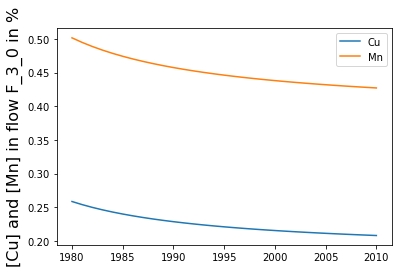

In [17]:
plt.set_loglevel("info") 
Concentration_F_3_0_Vb = np.einsum('te,t->te',
                                   Dyn_MFA_System.FlowDict['F_3_0'].Values, 
                                   1 / Dyn_MFA_System.FlowDict['F_3_0'].Values.sum(axis=1))
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
        100* Concentration_F_3_0_Vb[:,1::])
ax.set_ylabel('[Cu] and [Mn] in flow F_3_0 in %', fontsize =16)
ax.legend(['Cu','Mn'])

In [18]:
print(Concentration_F_3_0[0,1::])
print(Concentration_F_3_0_Va[0,1::])
print(Concentration_F_3_0_Vb[0,1::])
# First value is [Cu], second value is [Mn].

[0.00293783 0.00553486]
[0.00243755 0.00553764]
[0.00258818 0.00501965]


We can see that both measures reduce the copper concentration in the secondary steel. For the first year, [Cu] is reduced from 0.294% to 0.244% if the Cu-yield into steel scrap of the shredder is reduced and to 0.259% if the EoL building flow treated is increased by 25%. The yield measure thus has a slightly higher impact on the copper contentration than the increase of a copper-poor scrap flow for dilution. In both cases the impact is not high enough to bring [Cu] to values below 0.04%, which is necessary for automotive applications.

## Save Data and Results
Save entire system: 

In [19]:
pickle.dump( {'MFATestSystem': Dyn_MFA_System}, open( "Tutorial2_MFATestSystem.p", "wb" ) )